<a href="https://colab.research.google.com/github/neet813/Inventory-SQL/blob/main/Inventory_Optimization_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Optimization — Colab Notebook (v1.0)
**Author:** NAVNEET KAUR

This notebook creates a SQL-first inventory balancing pipeline (Version 1).  
It uses anonymised warehouse names:
- `DC_MAIN`
- `DC_INTERNAL`
- `SUPPLIER_A`
- `SUPPLIER_B`

Run all cells sequentially. At the end you'll get:
- `outputs/stock_position.csv`
- `outputs/transfer_recommendations.csv`
- `repo_version1.zip` (ready to upload to GitHub)


In [10]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

BASE_DIR = Path("/content/inventory_project_simple")
DATA_DIR = BASE_DIR / "sample_data"
SQL_DIR = BASE_DIR / "sql"
OUT_DIR = BASE_DIR / "outputs"
DB_PATH = OUT_DIR / "inventory.db"

for d in [DATA_DIR, SQL_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Folders ready:", BASE_DIR)


Folders ready: /content/inventory_project_simple


In [11]:
np.random.seed(42)

n_products = 50
rows = []
for i in range(n_products):
    rows.append({
        "product_id": i+1,
        "sku": f"SKU-{i+1:03d}",
        "product_name": f"Product {i+1}",
        "weekly_outbound": max(1, int(np.random.normal(50, 30))),
        "DC_MAIN": max(0, int(np.random.poisson(50))),
        "DC_INTERNAL": max(0, int(np.random.poisson(150))),
        "SUPPLIER_A": max(0, int(np.random.poisson(400))),
        "SUPPLIER_B": max(0, int(np.random.poisson(400))),
    })

df = pd.DataFrame(rows)
csv_path = DATA_DIR / "inventory_sample.csv"
df.to_csv(csv_path, index=False)
df.head()


,product_id,sku,product_name,weekly_outbound,DC_MAIN,DC_INTERNAL,SUPPLIER_A,SUPPLIER_B
0,1,SKU-001,Product 1,64,55,136,406,422
1,2,SKU-002,Product 2,45,43,143,396,406
2,3,SKU-003,Product 3,22,49,138,405,406
3,4,SKU-004,Product 4,7,46,157,373,385
4,5,SKU-005,Product 5,56,51,153,367,352


In [12]:
conn = sqlite3.connect(DB_PATH)
df.to_sql("csv_import_raw", conn, index=False, if_exists="replace")

# Create long table
conn.execute("DROP TABLE IF EXISTS inventory_long")
conn.execute("""
CREATE TABLE inventory_long AS
SELECT product_id, sku, product_name, weekly_outbound,
       'DC_MAIN' AS warehouse, DC_MAIN AS current_stock FROM csv_import_raw
UNION ALL
SELECT product_id, sku, product_name, weekly_outbound,
       'DC_INTERNAL', DC_INTERNAL FROM csv_import_raw
UNION ALL
SELECT product_id, sku, product_name, weekly_outbound,
       'SUPPLIER_A', SUPPLIER_A FROM csv_import_raw
UNION ALL
SELECT product_id, sku, product_name, weekly_outbound,
       'SUPPLIER_B', SUPPLIER_B FROM csv_import_raw
""")
print("Inventory long table created.")


Inventory long table created.


In [13]:
# Compute target units per warehouse
conn.execute("DROP TABLE IF EXISTS inventory_targets")
conn.execute("""
CREATE TABLE inventory_targets AS
SELECT *,
  CASE
    WHEN warehouse='DC_MAIN' THEN 0
    WHEN warehouse='DC_INTERNAL' THEN 4
    WHEN warehouse='SUPPLIER_A' THEN 8
    WHEN warehouse='SUPPLIER_B' THEN 8
    ELSE 4
  END AS target_weeks,
  weekly_outbound *
  CASE
    WHEN warehouse='DC_MAIN' THEN 0
    WHEN warehouse='DC_INTERNAL' THEN 4
    WHEN warehouse='SUPPLIER_A' THEN 8
    WHEN warehouse='SUPPLIER_B' THEN 8
    ELSE 4
  END AS target_units
FROM inventory_long
""")
print("Stock targets computed.")


Stock targets computed.


In [15]:
conn.execute("DROP TABLE IF EXISTS stock_position")
conn.execute("""
CREATE TABLE stock_position AS
SELECT *,
       target_units - current_stock AS shortage,
       current_stock - target_units AS surplus
FROM inventory_targets
""")
print("Stock position table ready.")

# Preview
pd.read_sql("SELECT * FROM stock_position LIMIT 8", conn)


Stock position table ready.


,product_id,sku,product_name,weekly_outbound,warehouse,current_stock,target_weeks,target_units,shortage,surplus
0,1,SKU-001,Product 1,64,DC_MAIN,55,0,0,-55,55
1,2,SKU-002,Product 2,45,DC_MAIN,43,0,0,-43,43
2,3,SKU-003,Product 3,22,DC_MAIN,49,0,0,-49,49
3,4,SKU-004,Product 4,7,DC_MAIN,46,0,0,-46,46
4,5,SKU-005,Product 5,56,DC_MAIN,51,0,0,-51,51
5,6,SKU-006,Product 6,1,DC_MAIN,48,0,0,-48,48
6,7,SKU-007,Product 7,29,DC_MAIN,54,0,0,-54,54
7,8,SKU-008,Product 8,68,DC_MAIN,46,0,0,-46,46


In [16]:
conn.execute("DROP TABLE IF EXISTS transfer_recommendations")
conn.execute("""
CREATE TABLE transfer_recommendations AS
WITH shortages AS (
  SELECT * FROM stock_position WHERE shortage > 0
),
surpluses AS (
  SELECT * FROM stock_position WHERE surplus > 0
)
SELECT sh.product_id, sh.sku, sh.product_name,
       su.warehouse AS transfer_from,
       sh.warehouse AS transfer_to,
       CASE WHEN sh.shortage <= su.surplus THEN sh.shortage ELSE su.surplus END AS units_to_move
FROM shortages sh
JOIN surpluses su
  ON sh.product_id = su.product_id
WHERE (su.warehouse='DC_INTERNAL' AND sh.warehouse='DC_MAIN')
   OR (su.warehouse IN ('SUPPLIER_A','SUPPLIER_B') AND sh.warehouse='DC_INTERNAL')
ORDER BY sh.product_id
""")
print("Transfer recommendations generated.")

# Preview
pd.read_sql("SELECT * FROM transfer_recommendations LIMIT 10", conn)


Transfer recommendations generated.


,product_id,sku,product_name,transfer_from,transfer_to,units_to_move
0,2,SKU-002,Product 2,SUPPLIER_A,DC_INTERNAL,36
1,2,SKU-002,Product 2,SUPPLIER_B,DC_INTERNAL,37
2,14,SKU-014,Product 14,SUPPLIER_B,DC_INTERNAL,19
3,18,SKU-018,Product 18,SUPPLIER_A,DC_INTERNAL,16
4,18,SKU-018,Product 18,SUPPLIER_B,DC_INTERNAL,16
5,24,SKU-024,Product 24,SUPPLIER_A,DC_INTERNAL,51
6,24,SKU-024,Product 24,SUPPLIER_B,DC_INTERNAL,36
7,37,SKU-037,Product 37,SUPPLIER_A,DC_INTERNAL,33
8,37,SKU-037,Product 37,SUPPLIER_B,DC_INTERNAL,23
9,38,SKU-038,Product 38,SUPPLIER_B,DC_INTERNAL,7


In [17]:
OUT_DIR.mkdir(parents=True, exist_ok=True)

stock_df = pd.read_sql("SELECT * FROM stock_position", conn)
transfer_df = pd.read_sql("SELECT * FROM transfer_recommendations", conn)

stock_df.to_csv(OUT_DIR / "stock_position.csv", index=False)
transfer_df.to_csv(OUT_DIR / "transfer_recommendations.csv", index=False)

print("Outputs saved to:", OUT_DIR)
stock_df.head(5), transfer_df.head(5)


Outputs saved to: /content/inventory_project_simple/outputs


(   product_id      sku product_name  weekly_outbound warehouse  current_stock  \
 0           1  SKU-001    Product 1               64   DC_MAIN             55   
 1           2  SKU-002    Product 2               45   DC_MAIN             43   
 2           3  SKU-003    Product 3               22   DC_MAIN             49   
 3           4  SKU-004    Product 4                7   DC_MAIN             46   
 4           5  SKU-005    Product 5               56   DC_MAIN             51   
 
    target_weeks  target_units  shortage  surplus  
 0             0             0       -55       55  
 1             0             0       -43       43  
 2             0             0       -49       49  
 3             0             0       -46       46  
 4             0             0       -51       51  ,
    product_id      sku product_name transfer_from  transfer_to  units_to_move
 0           2  SKU-002    Product 2    SUPPLIER_A  DC_INTERNAL             36
 1           2  SKU-002    Product 

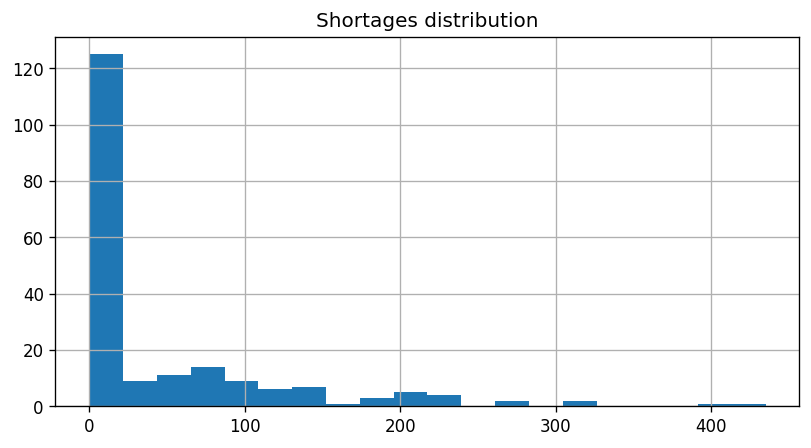

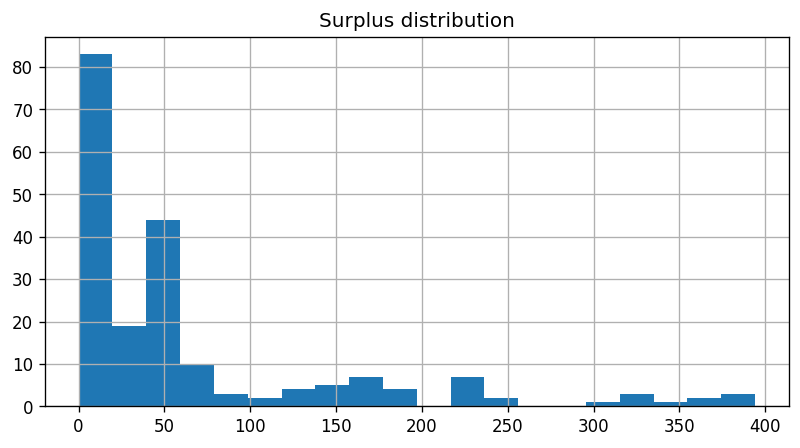

In [18]:
plt.figure(figsize=(8,4))
stock_df['shortage'].clip(0).hist(bins=20)
plt.title("Shortages distribution")
plt.show()

plt.figure(figsize=(8,4))
stock_df['surplus'].clip(0).hist(bins=20)
plt.title("Surplus distribution")
plt.show()


In [19]:
# Add unit cost if not already present (simulated)
if 'unit_cost' not in stock_df.columns:
    np.random.seed(42)
    stock_df['unit_cost'] = np.round(np.random.uniform(5, 120, size=len(stock_df)), 2)

# Compute overstock (surplus > 0) and total cost
overstock_df = stock_df[stock_df['surplus'] > 0].copy()
overstock_df['overstock_cost'] = overstock_df['surplus'] * overstock_df['unit_cost']

# Select relevant columns
overstock_report = overstock_df[['product_id','sku','product_name','warehouse','surplus','unit_cost','overstock_cost']]

# Preview
overstock_report.sort_values(['warehouse','surplus'], ascending=[True, False]).head(10)


,product_id,sku,product_name,warehouse,surplus,unit_cost,overstock_cost
55,6,SKU-006,Product 6,DC_INTERNAL,159,111.02,17652.18
53,4,SKU-004,Product 4,DC_INTERNAL,129,107.91,13920.39
77,28,SKU-028,Product 28,DC_INTERNAL,119,13.52,1608.88
74,25,SKU-025,Product 25,DC_INTERNAL,118,86.29,10182.22
96,47,SKU-047,Product 47,DC_INTERNAL,81,65.11,5273.91
65,16,SKU-016,Product 16,DC_INTERNAL,62,67.41,4179.42
75,26,SKU-026,Product 26,DC_INTERNAL,61,88.84,5419.24
66,17,SKU-017,Product 17,DC_INTERNAL,59,21.21,1251.39
93,44,SKU-044,Product 44,DC_INTERNAL,52,69.55,3616.60
52,3,SKU-003,Product 3,DC_INTERNAL,50,113.04,5652.00


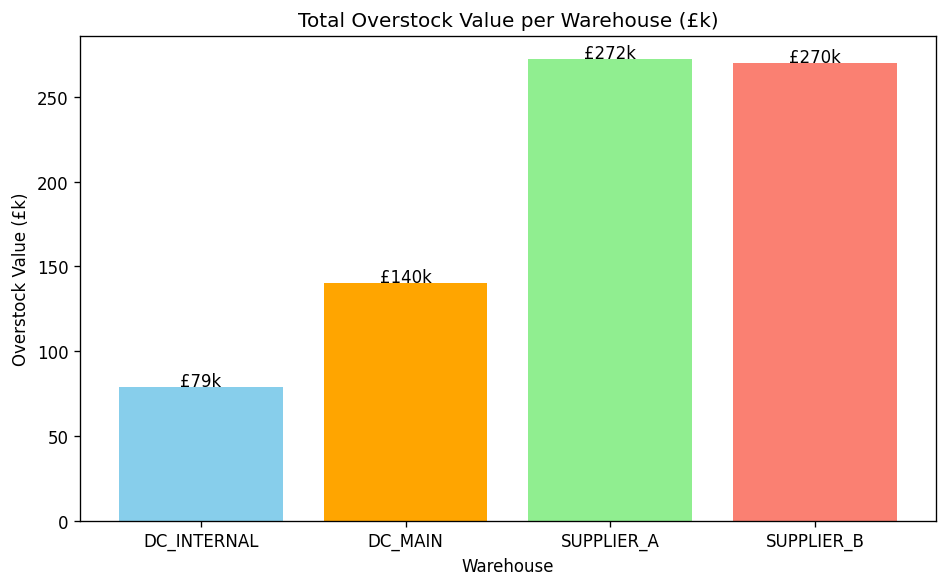

In [23]:
# Group by warehouse and sum overstock cost
overstock_summary = overstock_report.groupby('warehouse')['overstock_cost'].sum().reset_index()

# Scale to thousands for better visualization
overstock_summary['overstock_k'] = overstock_summary['overstock_cost'] / 1000

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(overstock_summary['warehouse'], overstock_summary['overstock_k'], color=['skyblue','orange','lightgreen','salmon'])
plt.title("Total Overstock Value per Warehouse (£k)")
plt.xlabel("Warehouse")
plt.ylabel("Overstock Value (£k)")
plt.xticks(rotation=0)
plt.tight_layout()

# Show numeric values on top of bars with £ sign
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"£{height:.0f}k", ha='center')

plt.show()


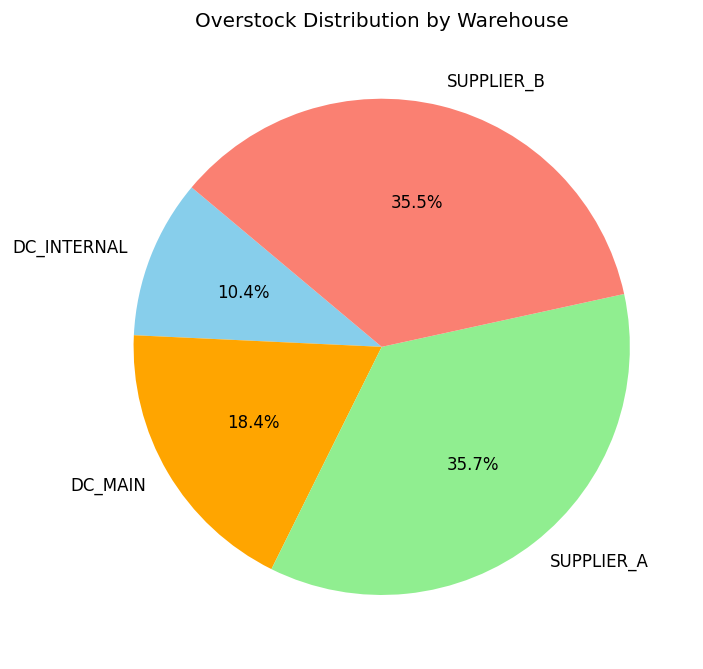

In [28]:
# Pie chart for overstock distribution by warehouse
plt.figure(figsize=(6,6))
plt.pie(overstock_summary['overstock_cost'],
        labels=overstock_summary['warehouse'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['skyblue','orange','lightgreen','salmon'])
plt.title("Overstock Distribution by Warehouse")
plt.tight_layout()
plt.show()


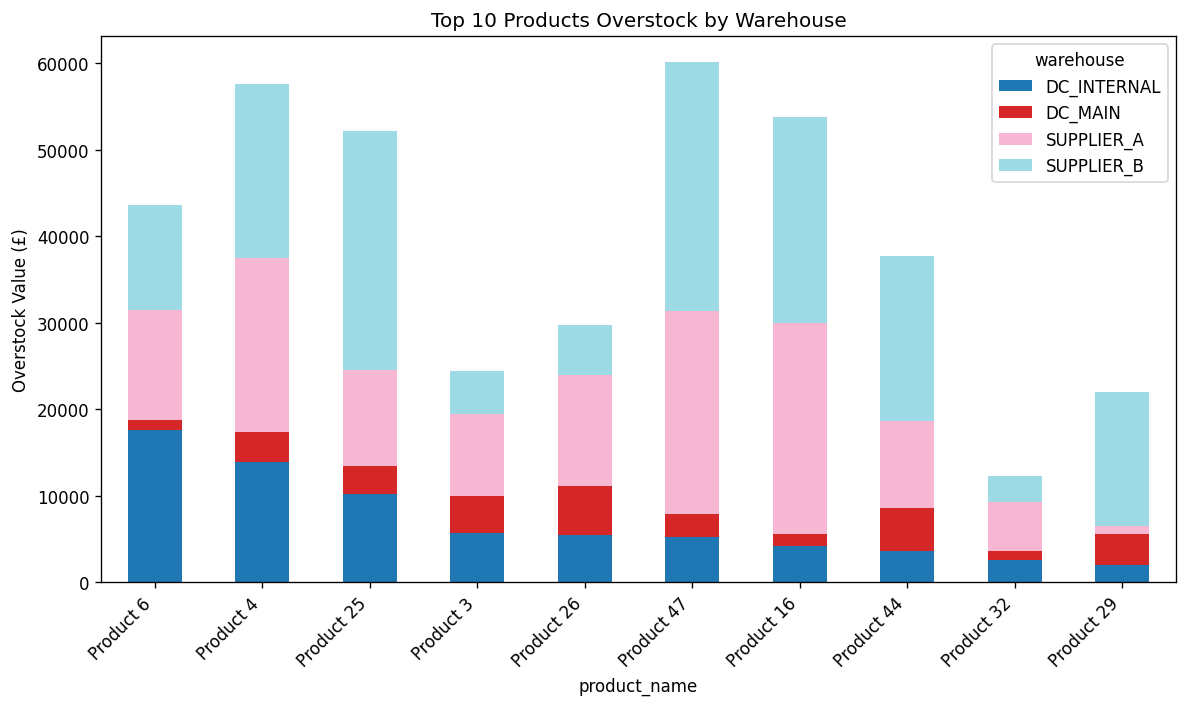

In [30]:
top10_warehouse = overstock_report.groupby(['product_name','warehouse'])['overstock_cost'].sum().unstack(fill_value=0)
top10_warehouse = top10_warehouse.sort_values(top10_warehouse.columns[0], ascending=False).head(10)

top10_warehouse.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.ylabel("Overstock Value (£)")
plt.title("Top 10 Products Overstock by Warehouse")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
